In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("derrom/")
sys.path.append("ELPH/")
sys.path.append("utils/")

import derrom
import ivp_integrator
import PHELPH

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
I_trajectories = derrom.utils.load_trajectories(filename='../PHELPH_I_kmax2.5_nkmax_100_n1000_v2.npz')
el_trajectories = derrom.utils.load_trajectories(filename='../PHELPH_el_kmax2.5_nkmax_100_n1000_v6.npz')
el_scattering = derrom.utils.load_trajectories(filename='../PHELPH_el_scat_kmax2.5_nkmax_100_n1000_v6.npz')

n_sample = 1

I_trajectories = I_trajectories[::n_sample]
el_trajectories = el_trajectories[::n_sample]
el_scattering = el_scattering[::n_sample]

n_trajectories = len(el_trajectories)
n_kmax = el_trajectories[0].shape[1]

trajectories = [ np.concatenate([el_trajectories[k],I_trajectories[k].reshape(-1,1)], axis=1) for k in range(n_trajectories) ]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


cutoff = int(n_trajectories*0.9)

train_I_trajectories = I_trajectories[:cutoff]
train_el_trajectories = el_trajectories[:cutoff]
train_el_scattering = el_scattering[:cutoff]

test_I_trajectories = I_trajectories[cutoff:]
test_el_trajectories = el_trajectories[cutoff:]
test_el_scattering = el_scattering[cutoff:]

test_trajectories = trajectories[cutoff:]

1000 loaded with n_kmax = 100


In [47]:
dim_reducer = derrom.dim_reducers.SVD()

scaler = derrom.scalers.standardize_scaler(1.0)
transformer = derrom.transformers.ELM_features(ELM_nodes=1000)
optimizer = derrom.optimizers.ridge(alpha=10.**4)

# scaler = derrom.scalers.normalize_scaler(0.1)
# transformer = derrom.transformers.polynomial_features(order=2)
# optimizer = derrom.optimizers.ridge(alpha=10.**-1)

model = derrom.derrom(rdim=8, DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)

model.fit(train_el_trajectories, train_el_scattering)

model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  8
DE_l:  2
weights shape:  (1017, 100)


In [56]:
derrom.utils.save_model(model,'../el_scat_model_ext_I.obj')

In [9]:
kmax = 2.5
n_kmax = 100

tmax = 10000
n_tmax = 1001
t_vec = np.linspace(0,tmax,n_tmax)

system = PHELPH.PHELPH(kmax=kmax, n_kmax=n_kmax)

v = 'v2'
system.g_photon = 0.02
system.tau_photon = 200
system.E_photon = 0.0175
system.linewidth = 0.005

In [10]:
def derivs(y):
    
    el_hist = y[:,:-1]
    el_state = y[-1,:-1]
    I = y[-1,-1]
    
    df = model.predict(el_hist)
    df += -system.g_photon * I * system.lineshape_vec * (2.*el_state - 1.0)
    
    
    dI = -I/system.tau_photon + I * np.sum(system.I_gain_helper_vec * (2.*el_state - 1.0))
    dI += 1e-9
    
    return np.concatenate((df[0],[dI]))

from ivp_integrator import PHELPH_ivp_integrator

integrator = PHELPH_ivp_integrator(model, derivs, dt=5.0, dt_out=10., method='Heun')

(1, 101)


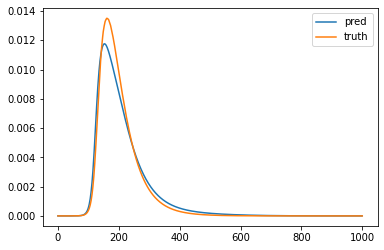

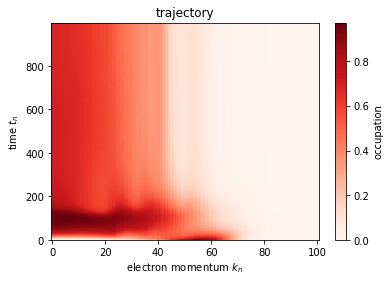

In [55]:
ind = 3
test_trajectory = test_trajectories[ind]

# inits = test_trajectory[:1]
inits = np.concatenate([test_trajectory[0,:system.n_kmax],[1e-6]]).reshape(1,-1)
print(inits.shape)

# inits = system.get_init_cond_gauss(max_pos = 0.15, width = 0.05, density=0.12, I_0=1e-6)
# inits = np.concatenate([inits[:system.n_kmax],[inits[-1]]]).reshape(1,-1)

pred = integrator.integrate(inits,1000)

plt.plot(pred[:,-1],label='pred')
plt.plot(test_trajectory[:,-1],label='truth')
plt.legend()
plt.show()

derrom.utils.plot_trajectory(pred)

In [44]:
dim_reducer = derrom.dim_reducers.SVD()

scaler = derrom.scalers.standardize_scaler(1.0)
transformer = derrom.transformers.ELM_features(ELM_nodes=1000)
optimizer = derrom.optimizers.ridge(alpha=10.**4)

# scaler = derrom.scalers.normalize_scaler(0.1)
# transformer = derrom.transformers.polynomial_features(order=2)
# optimizer = derrom.optimizers.ridge(alpha=10.**-2.)

el_scat_model = derrom.derrom(rdim=8, DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)

integrator = ivp_integrator.PHELPH_ivp_integrator(el_scat_model, derivs, dt=5.0, dt_out=10., method='Heun')

scores = derrom.utils.get_KFold_CV_scores(integrator, trajectories, el_scattering, folds=10, seed=817,
                                          norms=['rms','max','I_max','I_max_pos','I_area'],
                                          train_kwargs={})

print('rms error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )
print('I_max error: ', str(np.mean(scores[2])) + ' +- ' + str(np.std(scores[2])) )
print('I_max_pos error: ', str(np.mean(scores[3])) + ' +- ' + str(np.std(scores[3])) )
print('I_area error: ', str(np.mean(scores[4])) + ' +- ' + str(np.std(scores[4])) )

rms error:  0.05168204271679835 +- 0.018825911231606797
max error:  0.2238411133046718 +- 0.07394912617000285
I_max error:  -0.0006998505742451254 +- 0.0006558576955205092
I_max_pos error:  -101.97 +- 177.08929696624807
I_area error:  0.00547372246380176 +- 0.09538561988617136


0.008485126029804786
0.9443071608635486
rms error:  0.05168204271679835 +- 0.018825911231606797
max error:  0.2238411133046718 +- 0.07394912617000285
I_max error:  0.09443116952574049 +- 0.07729498574526161
I_max_pos error:  142.33 +- 177.08929696624807
I_area error:  0.08214742345154266 +- 0.10101122160181784


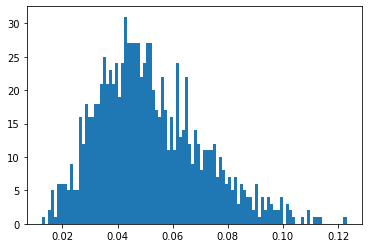

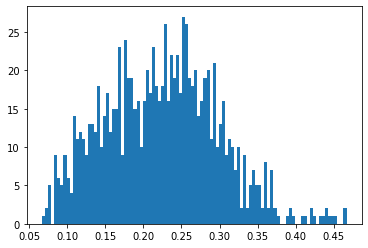

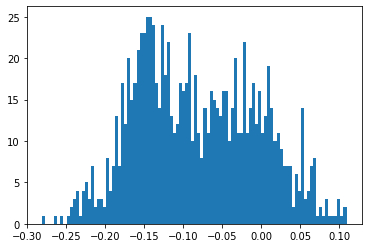

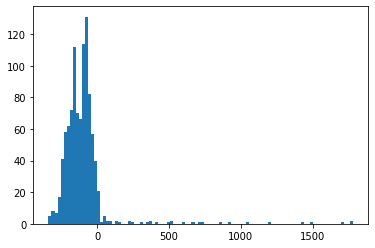

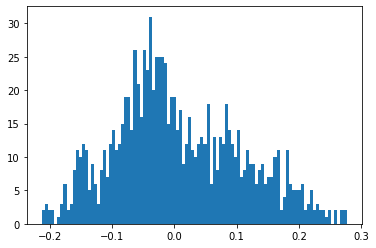

In [45]:
mean_I_max = np.mean([I.max() for I in I_trajectories])
print(mean_I_max)
mean_I_area = np.mean([np.sum(I) for I in I_trajectories])
print(mean_I_area)


print('rms error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )
print('I_max error: ', str(np.mean(np.abs(scores[2]))/mean_I_max) + ' +- ' + str(np.std(scores[2])/mean_I_max) )
print('I_max_pos error: ', str(np.mean(np.abs(scores[3]))) + ' +- ' + str(np.std(scores[3])) )
print('I_area error: ', str(np.mean(np.abs(scores[4]))/mean_I_area) + ' +- ' + str(np.std(scores[4])/mean_I_area) )

plt.hist(scores[0],bins=len(scores[0])//10)
plt.show()

plt.hist(scores[1],bins=len(scores[1])//10)
plt.show()

plt.hist(scores[2]/mean_I_max,bins=len(scores[2])//10)
plt.show()

plt.hist(np.array(scores[3]),bins=len(scores[3])//10)
plt.show()

plt.hist(scores[4]/mean_I_area,bins=len(scores[4])//10)
plt.show()

In [35]:
true_el_trajectories = derrom.utils.load_trajectories(filename='../PHELPH_el_kmax2.5_nkmax_100_n1000_v2.npz')

n_sample = 1

true_el_trajectories = true_el_trajectories[::n_sample]

true_trajectories = [ np.concatenate([true_el_trajectories[k],I_trajectories[k].reshape(-1,1)], axis=1) for k in range(n_trajectories) ]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


ttrta_scores = []

for trajectory in trajectories:
    
    ttrt_inits = np.concatenate([trajectory[0,:system.n_kmax],[system.T_cryo],[trajectory[0,-1]]])
    ttrt_approx = system.two_temperature_rel_time_approx(ttrt_inits,tmax=tmax, n_tmax=n_tmax,tau_rel=500,tau_Tp=4000)
    
    ttrt_approx = np.concatenate([ttrt_approx[:,:-2],ttrt_approx[:,-1:]],axis=1)
    
    el_rms = integrator.get_error(trajectory,ttrt_approx, norm='rms')
    el_max = integrator.get_error(trajectory,ttrt_approx, norm='max')
    I_max = integrator.get_error(trajectory,ttrt_approx, norm='I_max')
    I_max_pos = integrator.get_error(trajectory,ttrt_approx, norm='I_max_pos')
    I_area = integrator.get_error(trajectory,ttrt_approx, norm='I_area')
    
    ttrta_scores.append([el_rms,el_max,I_max,I_max_pos,I_area])

1000 loaded with n_kmax = 100
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.2614119940284381   mu= 0.2510485809355026   E= 0.032717516118871526   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.22659685022708603   mu= 0.21702948361729538   E= 0.024583122356851592   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.19426850241154478   mu= 0.18564773396075232   E= 0.01806899883328886   T= 0.0
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= 0.008202883091266244 , en= 0.0034662397470007038
calc_fermi_CC_eh: d= 5.565278136899877e-06 , E= 1.2170188728858927e-06
calc_fermi_CC_eh: mu= -9.89999999999998 , T= 10300.0
calc_fermi_CC_eh: error= 0.9996488936248743  nach  99  Schritten
fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.41638911986417115   mu= 0.4   E= 0.08300954842280328   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.126826

fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= -0.2027235592991758 , en= 0.0036750947108548267
calc_fermi_CC_eh: d= 5.565278136899877e-06 , E= 1.2170188728858927e-06
calc_fermi_CC_eh: mu= -9.89999999999998 , T= 10300.0
calc_fermi_CC_eh: error= 1.0000274525474797  nach  99  Schritten
fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.41638911986417115   mu= 0.4   E= 0.08300954842280328   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.18203346616135532   mu= 0.17639839776667282   E= 0.01586469702965964   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.13707219473789486   mu= 0.12880946202084026   E= 0.008995556557218254   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.18810124836673384   mu= 0.17900833892032525   E= 0.01693997093944768   T= 0.0
fit_mu braucht mehr als STEP_LIMIT Schritte

calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.41638911986417115   mu= 0.4   E= 0.08300954842280328   T= 0.0
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= 0.022420194366587088 , en= 0.005874884966672202
calc_fermi_CC_eh: d= 5.618338028159662e-06 , E= 1.2286220594991653e-06
calc_fermi_CC_eh: mu= -9.891659323919873 , T= 10300.0
calc_fermi_CC_eh: error= 0.9997908687461169  nach  99  Schritten
fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.41638911986417115   mu= 0.4   E= 0.08300954842280328   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.39838471692690053   mu= 0.37759952191697155   E= 0.07598618560517376   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.1218530033047324   mu= 0.11442174907215139   E= 0.007108889778773028   T= 0.0
fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc

calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= 0.030174238981395454 , en= 0.006873546157625694
calc_fermi_CC_eh: d= 5.665215003208106e-06 , E= 1.238873160418981e-06
calc_fermi_CC_eh: mu= -9.884355838919513 , T= 10300.0
calc_fermi_CC_eh: error= 0.9998197621530417  nach  99  Schritten
fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.41638911986417115   mu= 0.4   E= 0.08300954842280328   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.1531866327259493   mu= 0.14776802356070262   E= 0.01123494743812619   T= 0.0
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= 0.0008522125628393746 , en= 0.0072149151465553335
calc_fermi_CC_eh: d= 5.565278136899877e-06 , E= 1.2170188728858927e-06
calc_fermi_CC_eh: mu= -9.89999999999998 , T= 10300.0
calc_fermi_CC_eh: error= 0.999831319031733  nach  9

calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.11220423487978623   mu= 0.1060517587418953   E= 0.006027646888645958   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.41638911986417115   mu= 0.3945604581025448   E= 0.08300954842280328   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.1644269505818144   mu= 0.1560152184193479   E= 0.012944202856494749   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.24718752098959998   mu= 0.2372781313433678   E= 0.029253806836567215   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.18203346616135532   mu= 0.1765954420600672   E= 0.01586469702965964   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.20053522829578815   mu= 0.1913136978358421   E= 0.019253542981568984   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.1531866327259493   mu= 0.14708247703654667   E= 0.01123494743812619   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.14771568155716538   mu= 0.1428573380199858

calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.18810124836673384   mu= 0.18006661984977493   E= 0.01693997093944768   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.1531866327259493   mu= 0.1453053532090298   E= 0.01123494743812619   T= 0.0
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= 0.15557974075057876 , en= 0.00483967155097962
calc_fermi_CC_eh: d= 7.11136643927682e-06 , E= 1.8750785483511241e-06
calc_fermi_CC_eh: mu= 9.58890442558937 , T= -9700.0
calc_fermi_CC_eh: error= 0.9999542911795265  nach  99  Schritten
fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= -0.1453187963054682 , en= 0.003546022357896038
calc_fermi_CC_eh: d= 5.565278136899877e-06 , E= 1.2170188728858927e-06
calc_fermi_CC_eh: mu= -9.89999999999998 , T= 10300.0
calc_fermi_CC_eh: error= 1.0000382970288662

calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.41638911986417115   mu= 0.4   E= 0.08300954842280328   T= 0.0
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.1169788831725431   mu= 0.11187773693854389   E= 0.006551552820117223   T= 0.0
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= 0.007394120169329079 , en= 0.008311215376406379
calc_fermi_CC_eh: d= 5.565278136899877e-06 , E= 1.2170188728858927e-06
calc_fermi_CC_eh: mu= -9.89999999999998 , T= 10300.0
calc_fermi_CC_eh: error= 0.9998535690849331  nach  99  Schritten
fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.41638911986417115   mu= 0.4   E= 0.08300954842280328   T= 0.0
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= 0.007786557361484833 , en= 0.005868098071349416
calc_fermi_CC_eh: d= 5.565278136899877e-06 , E= 1.217018872885

fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.41638911986417115   mu= 0.4   E= 0.08300954842280328   T= 0.0
fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= -0.028996544460579896 , en= 0.0036233761314534373
calc_fermi_CC_eh: d= 5.565278136899877e-06 , E= 1.2170188728858927e-06
calc_fermi_CC_eh: mu= -9.89999999999998 , T= 10300.0
calc_fermi_CC_eh: error= 1.0001919290122472  nach  99  Schritten
fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.41638911986417115   mu= 0.4   E= 0.08300954842280328   T= 0.0
fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= -0.008204823196511371 , en= 0.004146554019267588
calc_fermi_CC_eh: d= 5.565278136899877e-06 , E= 1.2170

calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= 0.12403621209789624 , en= 0.0055306167977052295
calc_fermi_CC_eh: d= 6.253405275725718e-06 , E= 1.648857211441083e-06
calc_fermi_CC_eh: mu= 9.695267204028891 , T= -9700.0
calc_fermi_CC_eh: error= 0.9999495840354203  nach  99  Schritten
fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= -0.34344047265299954 , en= 0.002454913248185471
calc_fermi_CC_eh: d= 5.565278136899877e-06 , E= 1.2170188728858927e-06
calc_fermi_CC_eh: mu= -9.89999999999998 , T= 10300.0
calc_fermi_CC_eh: error= 1.0000162044912584  nach  99  Schritten
fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.41638911986417115   mu= 0.4   E= 0.08300954842280328   T= 0.0
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: 

In [59]:
ttscrs = np.asarray(ttrta_scores).T
print(ttscrs.shape)
# np.savetxt('../TTRTA_scores',  ttscrs)

(5, 1000)


In [37]:
ttscrs = np.loadtxt('../TTRTA_scores')

In [39]:
ML_scores = np.loadtxt('../PHELPH_ML_scores')
print(ML_scores.shape)

(5, 1000)


In [57]:
# np.savetxt('../PHELPH_ML_extI',  scores)

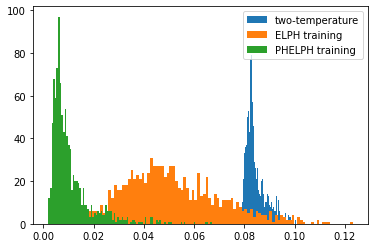

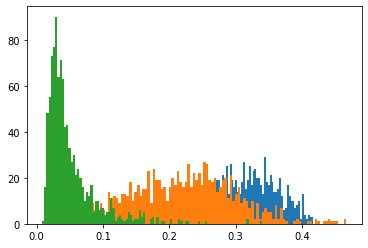

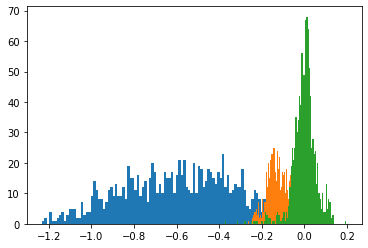

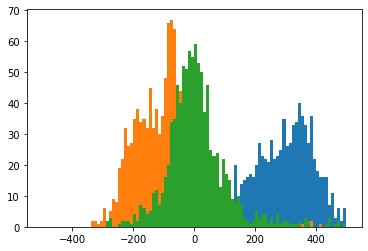

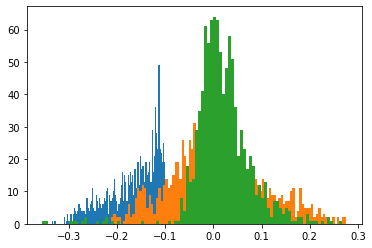

In [46]:
plt.hist(ttscrs[0], bins=100, label='two-temperature')
plt.hist(scores[0],bins=100, label='ELPH training')
plt.hist(ML_scores[0],bins=100, label='PHELPH training')
plt.legend()
plt.show()

plt.hist(ttscrs[1], bins=100)
plt.hist(scores[1],bins=100)
plt.hist(ML_scores[1],bins=100)
plt.show()

plt.hist(ttscrs[2]/mean_I_max, bins=100)
plt.hist(scores[2]/mean_I_max,bins=100)
plt.hist(ML_scores[2]/mean_I_max,bins=100)
plt.show()

plt.hist(ttscrs[3], bins=100,range=(-500,500))
plt.hist(scores[3],bins=100, range=(-500,500))
plt.hist(ML_scores[3],bins=100, range=(-500,500))
plt.show()

plt.hist(ttscrs[4]/mean_I_area, bins=100)
plt.hist(scores[4]/mean_I_area,bins=100)
plt.hist(ML_scores[4]/mean_I_area,bins=100)
plt.show()